# Analysis of Bay Area Bike Sharing

This notebook utilizes the public San Francisco Bay Area Bike Share [data](https://cloud.google.com/bigquery/public-data/bay-bike-share) on Google BigQuery to perform some exploratory analysis on data from [Ford GoBike](https://www.fordgobike.com/).  We will look at the trips to gain some insight on which ones are popular and offer some potential recommendations for further study.

We have data from 2013 to 2017.  During this time, users logged over 980,000 trips among 74 stations located across the Bay Area.

Below, we will perform some setup for analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_rel
%matplotlib inline

In [5]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 --maximum_bytes_billed=300000000 '
    SELECT
      COUNT(*) AS num_trips,
      AVG(duration_sec) AS average_duration,
      start_station_id,
      start_station_name,
      starts.dockcount AS start_dockcount,
      end_station_id,
      end_station_name,
      ends.dockcount AS end_dockcount,
      countIF(subscriber_type = "Subscriber") AS subscribers,
      countIF(subscriber_type = "Customer") AS customers
    FROM
      `bigquery-public-data.san_francisco.bikeshare_trips`
    JOIN
      `bigquery-public-data.san_francisco.bikeshare_stations` starts
    ON
      starts.station_id = start_station_id
    JOIN
      `bigquery-public-data.san_francisco.bikeshare_stations` ends
    ON
      ends.station_id = end_station_id
    GROUP BY
      start_station_id,
      start_station_name,
      end_station_id,
      end_station_name,
      start_dockcount,
      end_dockcount
    ORDER BY
      num_trips DESC' > trips.csv


Waiting on bqjob_r5b3f898f85d6703b_0000016406b74da9_1 ... (0s) Current status: DONE   

In [6]:
trips = pd.read_csv('trips.csv')
trips.head()

,num_trips,average_duration,start_station_id,start_station_name,start_dockcount,end_station_id,end_station_name,end_dockcount,subscribers,customers
0,9150,1188.003825,50,Harry Bridges Plaza (Ferry Building),23,60,Embarcadero at Sansome,15,5483,3667
1,8508,306.665961,69,San Francisco Caltrain 2 (330 Townsend),23,65,Townsend at 7th,15,8305,203
2,7620,581.754856,61,2nd at Townsend,27,50,Harry Bridges Plaza (Ferry Building),23,6931,689
3,6888,637.523229,50,Harry Bridges Plaza (Ferry Building),23,61,2nd at Townsend,27,6332,556
4,6874,511.009019,60,Embarcadero at Sansome,15,74,Steuart at Market,23,6200,674


## Most Popular Commuter Trips

In [65]:
n = 5 # change to see more trips
print("The %d most popular trips are" % n)
trips[:n][['start_station_name', 'start_dockcount', 'end_station_name', 'end_dockcount', 'num_trips']]

The 5 most popular trips are


,start_station_name,start_dockcount,end_station_name,end_dockcount,num_trips
0,Harry Bridges Plaza (Ferry Building),23,Embarcadero at Sansome,15,9150
1,San Francisco Caltrain 2 (330 Townsend),23,Townsend at 7th,15,8508
2,2nd at Townsend,27,Harry Bridges Plaza (Ferry Building),23,7620
3,Harry Bridges Plaza (Ferry Building),23,2nd at Townsend,27,6888
4,Embarcadero at Sansome,15,Steuart at Market,23,6874


The above trips are the most popular.  It probably makes sense to have more docks and bikes at these locations, so that riders will always have some available.  This is especially true at Harry Bridges Plaza, which appears three times in the top five commuter trips.
![harry-bridges-plaza](img/harry-bridges-plaza.jpg)

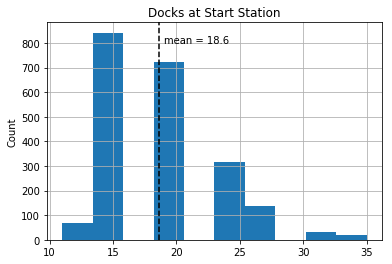

In [115]:
plt.hist(trips.start_dockcount)
plt.axvline(trips.start_dockcount.mean(), color='k', linestyle='dashed')
plt.text(19,800,'mean = %s' % round(trips.start_dockcount.mean(), 1))
plt.title('Docks at Start Station')
plt.ylabel('Count')
plt.grid()
plt.show()

It looks like with a dock count of 23, the company does have an above average number of dock counts at Harry Bridges Plaza already.  However, the Sansome station at the Embarcadero could use a few more docks.  Let us examine the average status of stations.  We'll need another bq query.

### statuses.csv
```sql
SELECT
  station_id,
  AVG(bikes_available) AS avg_bikes,
  AVG(docks_available) AS avg_docks
FROM
  `bigquery-public-data.san_francisco.bikeshare_status`
GROUP BY
  station_id
ORDER BY
  station_id
```

In [12]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 --maximum_bytes_billed=3000000000 '
    SELECT
      station_id,
      AVG(bikes_available) AS avg_bikes,
      AVG(docks_available) AS avg_docks
    FROM
      `bigquery-public-data.san_francisco.bikeshare_status`
    GROUP BY
      station_id
    ORDER BY
      station_id' > statuses.csv

Waiting on bqjob_r17513b63d1537642_0000016406b9d481_1 ... (1s) Current status: DONE   

In [13]:
statuses = pd.read_csv('statuses.csv')
#statuses = statuses.set_index('station_id')
statuses.head()

,station_id,avg_bikes,avg_docks
0,2,12.680102,14.229973
1,3,8.209532,6.779045
2,4,5.351653,5.630504
3,5,7.655210,11.320708
4,6,7.479085,7.502331


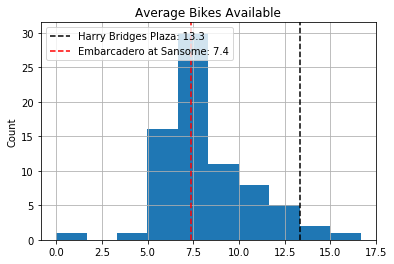

In [15]:
plt.hist(statuses.avg_bikes)
plt.axvline(statuses.loc[50].avg_bikes, color='k', linestyle='dashed',
           label='Harry Bridges Plaza: %s' % round(statuses.loc[50].avg_bikes,1))
plt.axvline(statuses.loc[60].avg_bikes, color='r', linestyle='dashed',
           label='Embarcadero at Sansome: %s' % round(statuses.loc[60].avg_bikes,1))
plt.title('Average Bikes Available')
plt.ylabel('Count')
plt.legend()
plt.grid()

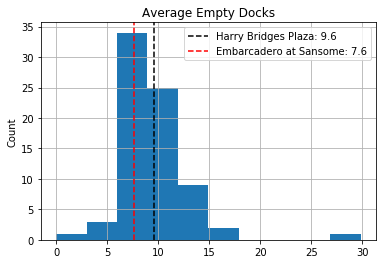

In [13]:
plt.hist(statuses.avg_docks)
plt.axvline(statuses.loc[50].avg_docks, color='k', linestyle='dashed', 
            label='Harry Bridges Plaza: %s' % round(statuses.loc[50].avg_docks,1))
plt.axvline(statuses.loc[60].avg_docks, color='r', linestyle='dashed', 
            label='Embarcadero at Sansome: %s' % round(statuses.loc[60].avg_docks,1))
plt.title('Average Empty Docks')
plt.ylabel('Count')
plt.legend()
plt.grid()

Given that Sansome station at Embarcadero is fifth most popular starting station, it makes sense to add more bikes/docks there.

## Subscribers and Customers

In [5]:
trips.head()

,num_trips,average_duration,start_station_id,start_station_name,start_dockcount,end_station_id,end_station_name,end_dockcount,subscribers,customers
0,9150,1188.003825,50,Harry Bridges Plaza (Ferry Building),23,60,Embarcadero at Sansome,15,5483,3667
1,8508,306.665961,69,San Francisco Caltrain 2 (330 Townsend),23,65,Townsend at 7th,15,8305,203
2,7620,581.754856,61,2nd at Townsend,27,50,Harry Bridges Plaza (Ferry Building),23,6931,689
3,6888,637.523229,50,Harry Bridges Plaza (Ferry Building),23,61,2nd at Townsend,27,6332,556
4,6874,511.009019,60,Embarcadero at Sansome,15,74,Steuart at Market,23,6200,674


The dataset segregates riders into two categories:
1. Subscribers - riders with an annual or 30-day membership
2. Customers - riders with a 24-hour or 3-day pass

Let us look at the relationship between subscribers and customers in the trips. One of the things that we notice is that the most popular trip, from Harry Bridges to Sansome, has a higher subscriber to customer ratio than the other top trips.  That is, it seems like there is some room here to turn some short term customers into long term subscribers.

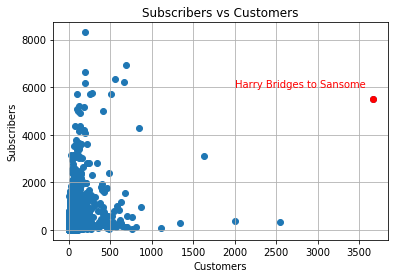

In [24]:
plt.scatter(trips.customers, trips.subscribers)
plt.plot(trips.iloc[0].customers, trips.iloc[0].subscribers, 'ro')
plt.text(2000, 6000, 'Harry Bridges to Sansome', color='r')
plt.xlabel('Customers')
plt.ylabel('Subscribers')
plt.title('Subscribers vs Customers')
plt.grid()

As we can see, the Harry Bridges to Sansome trip does seem to be an outlier in that there is a very low number of subscribers for the number of customers.  The company should do some surveying to ascertain why people are so frequently taking this trip, but not subscribing to a longer term membership.

In [9]:
print('Customers skew:', trips.customers.skew())
print('Subscribers skew:', trips.subscribers.skew())

Customers skew: 11.537511764366524
Subscribers skew: 4.406371937647082


Both customer and subscriber data are heavily right skewed.  Let us examine the log-log plot to further study the relationship.  We'll only look at trips with nonzero customers and subscribers to avoid taking the log of zero.

In [44]:
trips2 = trips[(trips.customers > 0) & (trips.subscribers > 0)]
print('Minimum customers:', min(trips2.customers))
print('Minimum subscribers:', min(trips2.subscribers))

Minimum customers:  1
Minimum subscribers:  1


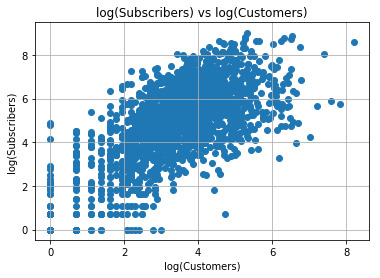

In [45]:
plt.scatter(np.log(trips2.customers), np.log(trips2.subscribers))
plt.xlabel('log(Customers)')
plt.ylabel('log(Subscribers)')
plt.title('log(Subscribers) vs log(Customers)')
plt.grid()

Let us fit a simple linear model.

In [52]:
X = np.log(trips2.customers).reshape([-1,1])
y = np.log(trips2.subscribers)

lm = LinearRegression()
lm.fit(X, y)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

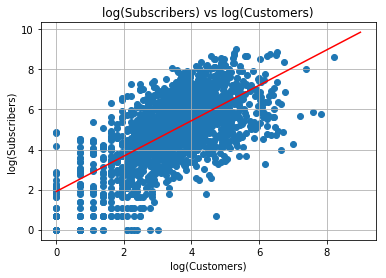

In [53]:
x = np.linspace(0,9,100)

plt.scatter(X, y)
plt.plot(x, lm.predict(x.reshape((-1,1))), color='r')
plt.xlabel('log(Customers)')
plt.ylabel('log(Subscribers)')
plt.title('log(Subscribers) vs log(Customers)')
plt.grid()

In [54]:
lm.score(X, y)

0.43321618482007296

It looks like there is weak correlation between customers and subscribers.  For some reason, riders prefer short-term payments on some trips and long-term payments on others.  Maybe this has something to do with duration of trip.  

## Time Analysis

In [14]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 --maximum_bytes_billed=3000000000 '
SELECT
  start_date,
  duration_sec,
  subscriber_type 
FROM
  `bigquery-public-data.san_francisco.bikeshare_trips`' > start_duration.csv

Waiting on bqjob_r3fca89acddd0a4af_0000016406baa9a5_1 ... (5s) Current status: DONE   

In [15]:
start_duration = pd.read_csv('start_duration.csv', parse_dates=['start_date'])
start_duration.head()

,start_date,duration_sec,subscriber_type
0,2015-01-22 14:15:00,256,Customer
1,2013-10-01 20:58:00,256,Customer
2,2013-10-12 16:14:00,256,Customer
3,2013-12-24 14:50:00,256,Customer
4,2013-09-02 04:37:00,256,Customer


In [21]:
gb = start_duration.groupby('subscriber_type')
gb.agg(['count', 'mean', 'std'])

duration_sec                          
                       count        mean           std
subscriber_type                                       
Customer              136809  3718.78516  48768.511911
Subscriber            846839   582.76424   2894.559209

We initially see that there are considerably more subscribers than customers, but the former makes far shorter trips.  However, the extremely high standard deviation on the customer data warrants further examination.

In [23]:
gb.describe()

duration_sec                                                 \
                       count        mean           std   min    25%     50%   
subscriber_type                                                               
Customer            136809.0  3718.78516  48768.511911  60.0  662.0  1130.0   
Subscriber          846839.0   582.76424   2894.559209  60.0  328.0   481.0   

                                     
                    75%         max  
subscriber_type                      
Customer         2360.0  17270400.0  
Subscriber        670.0   1852590.0

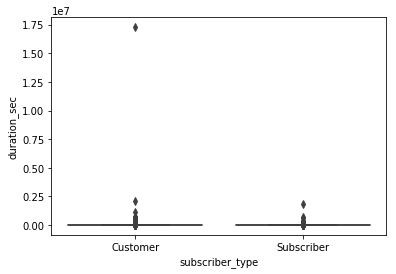

In [26]:
sns.boxplot(x='subscriber_type', y='duration_sec', data=start_duration)
plt.show()

There is a very large outlier in the customer durations.  Someone apparently made a trip that is 17,270,400 seconds long.  Since that amounts to a 200 day trip, we'll assume there is something wrong with this data point.  Customers are defined as those with 3-day memberships or less.  We will filter out all rides with duration greater than 3 days for now.  But the company should definitely investigate why bikes aren't being returned for several days.

In [51]:
start_duration2 = start_duration[start_duration.duration_sec < 259200]

In [40]:
gb = start_duration2.groupby('subscriber_type')
gb.describe()

duration_sec                                                 \
                       count         mean          std   min    25%     50%   
subscriber_type                                                               
Customer            136759.0  3418.234712  9156.444306  60.0  662.0  1130.0   
Subscriber          846831.0   577.248112  1656.917276  60.0  328.0   481.0   

                                   
                    75%       max  
subscriber_type                    
Customer         2357.0  258706.0  
Subscriber        670.0  250430.0

In [41]:
gb.agg(['count', 'mean', 'std'])

duration_sec                          
                       count         mean          std
subscriber_type                                       
Customer              136759  3418.234712  9156.444306
Subscriber            846831   577.248112  1656.917276

There are still a ton of outliers, so we will look at the boxplots with a truncated y axis.

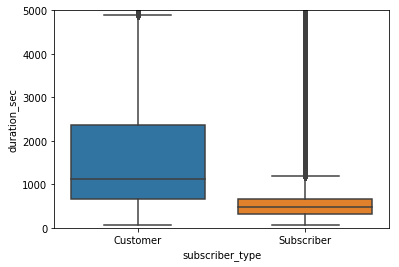

In [91]:
sns.boxplot(x='subscriber_type', y='duration_sec', data=start_duration2)
plt.ylim(0, 5000)
plt.show()

Next we will look at the fluctuations in ridership throughout the day.

In [48]:
start_duration2.dtypes


start_date         object
duration_sec        int64
subscriber_type    object
dtype: object

In [52]:
start_duration2 = start_duration2.assign(hour = start_duration2.start_date.dt.hour)

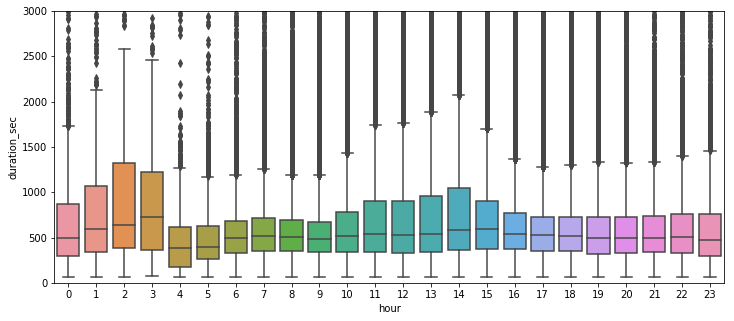

In [90]:
plt.figure(figsize=(12,5))
sns.boxplot(x='hour', y='duration_sec', data=start_duration2)
plt.ylim(0, 3000)
plt.show()

There seems to be a weird increase in ride duration for trips started in the middle of night.  Something changes between 3 AM and 4 AM and is worth investigating.  Perhaps late night riders are not returning the bikes.

In [82]:
gb = start_duration2.groupby('hour')
df = gb.count().reset_index()
df

,hour,start_date,duration_sec,subscriber_type
0,0,2929,2929,2929
1,1,1610,1610,1610
2,2,877,877,877
3,3,600,600,600
4,4,1398,1398,1398
5,5,5097,5097,5097
6,6,20516,20516,20516
7,7,67530,67530,67530
8,8,132460,132460,132460
9,9,96112,96112,96112


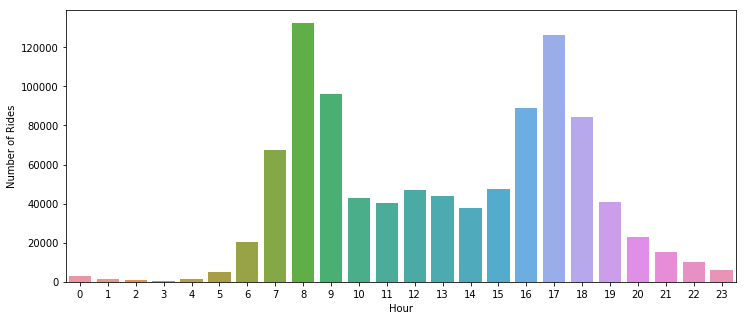

In [89]:
plt.figure(figsize=(12,5))
sns.barplot(df.hour, df.start_date)
plt.xlabel('Hour')
plt.ylabel('Number of Rides')
plt.show()

We see a clear spike in ridership at the 8 AM hour and the 5 PM hour.  This corresponds nicely with the standard American work schedule.  The company can look into special pricing during these times.